# Apply K means, Agglomerative & DBSCAN clustering algorithms on Donors Choose dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Loading Data

### Due to compuational resource constraints ,I will be considering 5k data points to run all the algorithms.

In [2]:
data = pd.read_csv('preprocessed_data.csv', nrows=5000)
data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... quantity  \
0  \"The limits of your language are the limits o...  ...       23   
1  The projector we need for our school is very c...  ...        1   

  Numerical digits in summary                                  titles_sw  \
0                           0  educational support english learners home   
1                           0           wanted projector hungry learners   

                                           essays_sw  \
0  my students english learners working english s...   
1  our students arrive school eager learn they po...   

   preprocessed_project_grade_category  \
0                        grades_prek_2   
1                           grades_6_8   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   

                         preprocessed_titles sentimental_score  \
0  educational support english learners home            0.9735   
1           wanted projector hungry learners            0.9856   

   preprocessed_essay_word_count  preprocessed_title_word_count  
0                            147                              5  
1                             97                              4  

[2 rows x 29 columns]

In [3]:
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'Numerical digits in summary', 'titles_sw', 'essays_sw',
       'preprocessed_project_grade_category', 'preprocessed_essays',
       'preprocessed_titles', 'sentimental_score',
       'preprocessed_essay_word_count', 'preprocessed_title_word_count'],
      dtype='object')

In [4]:
data['project_is_approved'].value_counts()

1    4237
0     763
Name: project_is_approved, dtype: int64

In [5]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... quantity  \
0  \"The limits of your language are the limits o...  ...       23   
1  The projector we need for our school is very c...  ...        1   

  Numerical digits in summary                                  titles_sw  \
0                           0  educational support english learners home   
1                           0           wanted projector hungry learners   

                                           essays_sw  \
0  my students english learners working english s...   
1  our students arrive school eager learn they po...   

  preprocessed_project_grade_category  \
0                       grades_prek_2   
1                          grades_6_8   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   

                         preprocessed_titles  sentimental_score  \
0  educational support english learners home             0.9735   
1           wanted projector hungry learners             0.9856   

   preprocessed_essay_word_count  preprocessed_title_word_count  
0                            147                              5  
1                             97                              4  

[2 rows x 28 columns]

## 1.2 Make Data Model Ready: encoding essay, and project_title using BOW

- In the Logistic Regression assignment I gor the highest test AUC for BOW vectorization compared to others
- Hence, I will be considering the data matrix obatined from BOW to select top 5K features

In [6]:
# preprocessed essays
print(X.shape, y.shape)
print("="*100)

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=7000)
vectorizer.fit(X['preprocessed_essays'].values)  # fit has to happen only on train data

# we use the fit CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X['preprocessed_essays'].values)

(5000, 28) (5000,)


essay_info = (vectorizer.get_feature_names(), X_train_essay_bow.toarray())

In [7]:
f1=vectorizer.get_feature_names()
print("After vectorization")
print(X_train_essay_bow.shape)
print("="*100)

After vectorization
(5000, 7000)


In [8]:
#project_title
vectorizer1 = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer1.fit(X['preprocessed_titles'].values.astype('U'))

X_train_title_bow = vectorizer1.transform(X['preprocessed_titles'].values.astype('U'))

In [9]:
f2=vectorizer.get_feature_names()
print("After vectorization")
print(X_train_title_bow.shape)
print("="*100)

After vectorization
(5000, 373)


## 1.3 Make Data Model Ready: encoding numerical, categorical features

### 1.3.1 Encoding categorical features: School State

In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(X['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state = vectorizer.transform(X['school_state'].values)
f5=vectorizer.get_feature_names()
print("After vectorizations")
print(X_train_state.shape)
print(f5)
print("="*100)

After vectorizations
(5000, 51)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 1.3.2 Encoding categorical features: teacher_prefix

In [11]:
X['teacher_prefix'].unique()

array(['Mrs.', 'Mr.', 'Ms.', 'Teacher'], dtype=object)

In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(X['teacher_prefix'].values) 

X_train_teacher = vectorizer.transform(X['teacher_prefix'].values)
f6=vectorizer.get_feature_names()
print("After vectorizations")
print(X_train_teacher.shape)
print(f6)
print("="*100)

After vectorizations
(5000, 4)
['mr', 'mrs', 'ms', 'teacher']


### 1.3.3 Encoding categorical features: project_grade_category

In [13]:
#This step is to intialize a vectorizer with vocab from train data
#Ref: https://www.kaggle.com/shashank49/donors-choose-knn#Concatinating-all-features-(TFIDF)
from collections import Counter
my_counter = Counter()
for word in X['project_grade_category'].values:
    my_counter.update([word[i:i+14] for i in range(0, len(word),14)]) #https://www.geeksforgeeks.org/python-string-split/

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

In [14]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True,max_features=4)
vectorizer.fit(X['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade = vectorizer.transform(X['project_grade_category'].values)

f7=vectorizer.get_feature_names()
print("After vectorizations")
print(X_train_grade.shape)
print(f7)

After vectorizations
(5000, 4)
['Grades 9-12', 'Grades 6-8', 'Grades 3-5', 'Grades PreK-2']


### 1.3.4 Encoding categorical features: clean_categories

In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(X['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat = vectorizer.transform(X['clean_categories'].values)

f8=vectorizer.get_feature_names()
print("After vectorizations")
print(X_train_cat.shape)
print(f8)
print("="*100)

After vectorizations
(5000, 9)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### 1.3.5 Encoding categorical features: clean_subcategories

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(X['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat = vectorizer.transform(X['clean_subcategories'].values)

f9=vectorizer.get_feature_names()
print("After vectorizations")
print(X_train_subcat.shape)
print(f9)
print("="*100)

After vectorizations
(5000, 30)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### 1.3.6 Encoding numerical features: Price

In [17]:
from sklearn.preprocessing import Normalizer
normalizer1 = Normalizer() 
# normalizer.fit(X_train['price'].values)
#this will rise an error Expected 2D array, got 1D array instead:
normalizer1.fit(X['price'].values.reshape(-1,1))

X_train_price_norm = normalizer1.transform(X['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape)
print("="*100)

After vectorizations
(5000, 1)


### 1.3.7 Encoding numerical features: Quantity

In [18]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.transform(X['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape)
print("="*100)

After vectorizations
(5000, 1)


### 1.3.8 Encoding numerical features: teacher_number_of_previously_posted_projects

In [19]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_projects_norm = normalizer.transform(X['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_projects_norm.shape)
print("="*100)

After vectorizations
(5000, 1)


### 1.3.9 Encoding numerical features: sentimental_score

In [20]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X['sentimental_score'].values.reshape(-1,1))

X_train_senti_norm = normalizer.transform(X['sentimental_score'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_senti_norm.shape)
print("="*100)

After vectorizations
(5000, 1)


### 1.3.10 Encoding numerical features: preprocessed_essay_word_count

In [21]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X['preprocessed_essay_word_count'].values.reshape(-1,1))

X_train_ewc_norm = normalizer.transform(X['preprocessed_essay_word_count'].values.reshape(-1,1))

print("After vectorization")
print(X_train_ewc_norm.shape)
print("="*100)

After vectorization
(5000, 1)


### 1.3.11 Encoding numerical features: preprocessed_title_word_count

In [22]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X['preprocessed_title_word_count'].values.reshape(-1,1))

X_train_twc_norm = normalizer.transform(X['preprocessed_title_word_count'].values.reshape(-1,1))

print("After vectorization")
print(X_train_twc_norm.shape)
print("="*100)

After vectorization
(5000, 1)


### 1.4 Concatinating all categorical features + numerical features + preprocessed_titles(BOW) + preprocessed_essays(BOW)

In [23]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_stack = hstack((X_train_essay_bow, X_train_title_bow, X_train_state, X_train_teacher, X_train_grade, X_train_cat, X_train_subcat, X_train_price_norm, X_train_quantity_norm, X_train_projects_norm,X_train_senti_norm,X_train_ewc_norm,X_train_twc_norm )).tocsr()

print("Final Data Matrix")
print(X_stack.shape)

Final Data Matrix
(5000, 7477)


## 2. Dimensionality Reduction on the selected features using sklearn selectkbest

In [24]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import SelectKBest, f_classif

X_final = SelectKBest(f_classif, k=5000).fit_transform(X_stack,y)

In [25]:
print("Shape of the data matrix after dim reduction :", X_final.shape)

Shape of the data matrix after dim reduction : (5000, 5000)


In [32]:
#saving the sparse matrix
# https://stackoverflow.com/questions/8955448/save-load-scipy-sparse-csr-matrix-in-portable-data-format
from scipy import sparse

sparse.save_npz("X_final.npz", X_final)
np.save('y', y)

In [ ]:
#loading the files
y = np.load('y.npy')
X_final = sparse.load_npz("X_final.npz")

## 3. Apply K-Means

### 3.1 Find best 'k' using using the elbow-knee method (plot k vs inertia_)

In [42]:
from sklearn.cluster import KMeans

loss=[]
k=[4, 8, 16, 25, 35]

for i in tqdm(k): #using simple for loop
    clf1 = KMeans(n_clusters=i, n_jobs=-1)
    clf1.fit(X_final)
    loss.append(clf1.inertia_)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [32:26<00:00, 379.05s/it]


### 3.2 plot k vs inertia_

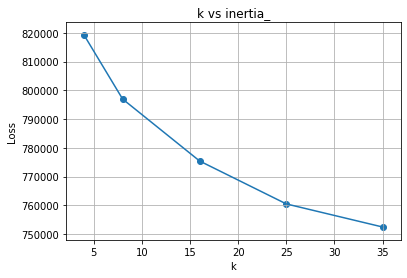

In [44]:
plt.plot(k, loss)
plt.scatter(k, loss)
plt.xlabel("k")
plt.ylabel("Loss")
plt.title("k vs inertia_")
plt.grid()
plt.show()

#### From the above plot I shall consider k=15

In [27]:
# Applying best n_clusters
from sklearn.cluster import KMeans
clf2 = KMeans(n_clusters=15, random_state=0, n_jobs=-1).fit(X_final)
#cluster_dict = getClusterDict(essay_info, clf2.labels_)
#cluster_dict = dict(sorted(list(cluster_dict.items()), key=lambda x: x[0]))

for key, val in cluster_dict.items():
    plotWordCloud(val, key,'KMeans')

### 3.3 Dataframe contaning the cluster numbers and the text

In [28]:
#Ref: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-samples-points-in-each-clusters

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['essay']= X['preprocessed_essays'].values
cluster_map['cluster'] = clf2.labels_

In [29]:
cluster_map.head(5)

data_index                                              essay  cluster
0           0  students english learners working english seco...        7
1           1  students arrive school eager learn polite gene...        7
2           2  true champions always ones win guts mia hamm q...       14
3           3  work unique school filled esl english second l...       10
4           4  second grade classroom next year made around 2...       11

### 3.4 Essay Wordcloud

Essay Wordcloud for cluster 0 :


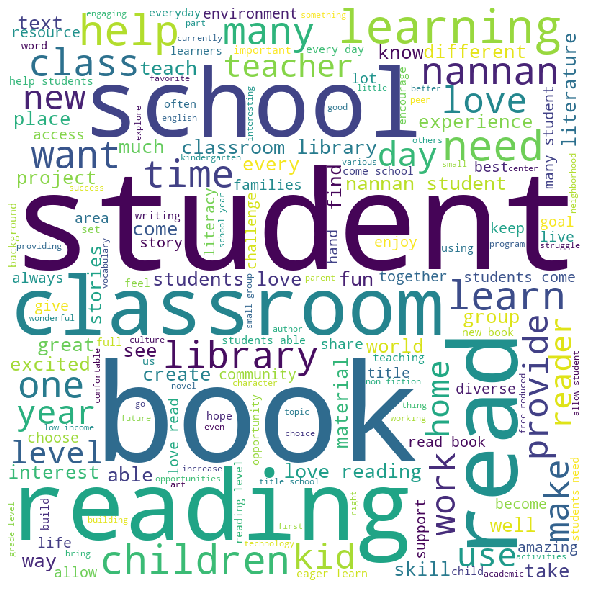

Summary of words in Cluster 0 :
Number of words in the cluster: 33246
Most frequent words in the cluster: [('students', 1435), ('books', 925), ('reading', 656), ('school', 567), ('read', 553), ('classroom', 423), ('love', 408), ('learning', 310), ('learn', 291), ('help', 265)]



Essay Wordcloud for cluster 1 :


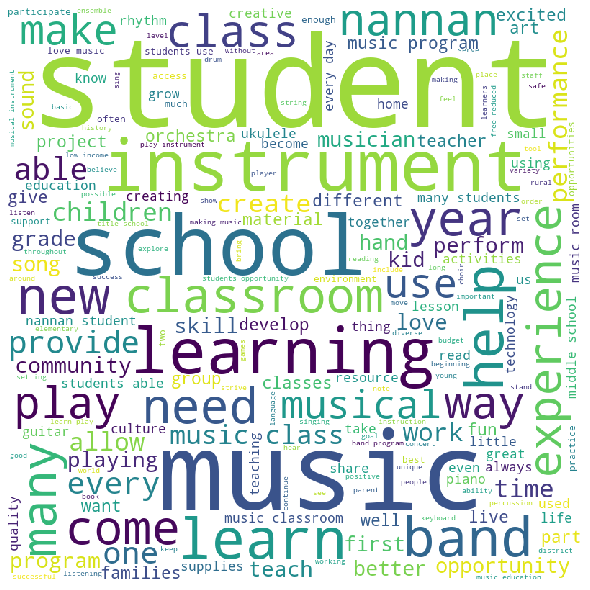

Summary of words in Cluster 1 :
Number of words in the cluster: 13058
Most frequent words in the cluster: [('students', 628), ('music', 601), ('school', 262), ('instruments', 134), ('learning', 119), ('learn', 112), ('class', 100), ('play', 97), ('many', 95), ('band', 94)]



Essay Wordcloud for cluster 2 :


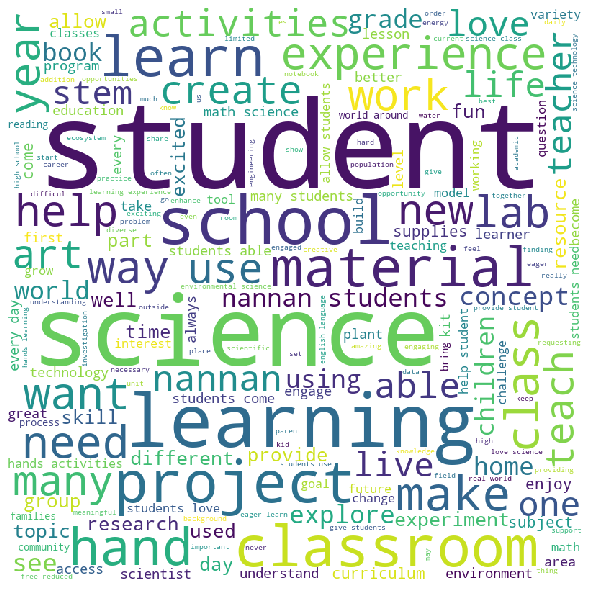

Summary of words in Cluster 2 :
Number of words in the cluster: 19445
Most frequent words in the cluster: [('students', 1033), ('science', 616), ('school', 283), ('learning', 276), ('hands', 156), ('learn', 148), ('classroom', 127), ('nannan', 119), ('help', 111), ('materials', 109)]



Essay Wordcloud for cluster 3 :


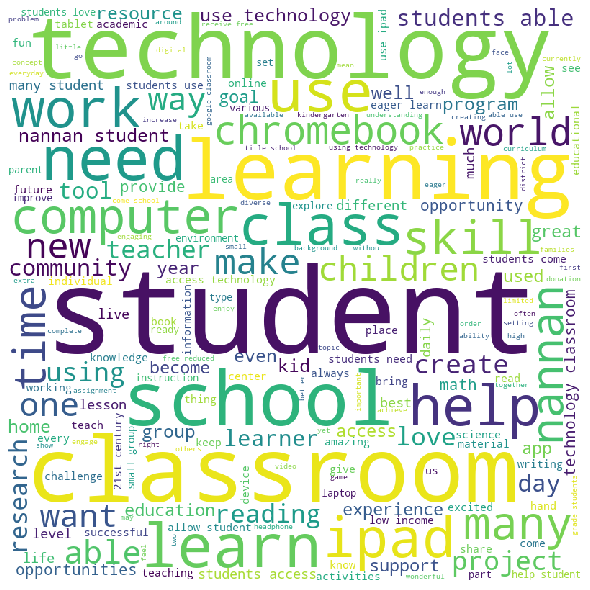

Summary of words in Cluster 3 :
Number of words in the cluster: 42503
Most frequent words in the cluster: [('students', 1890), ('technology', 946), ('classroom', 799), ('learning', 685), ('school', 644), ('use', 502), ('learn', 362), ('nannan', 321), ('able', 308), ('help', 295)]



Essay Wordcloud for cluster 4 :


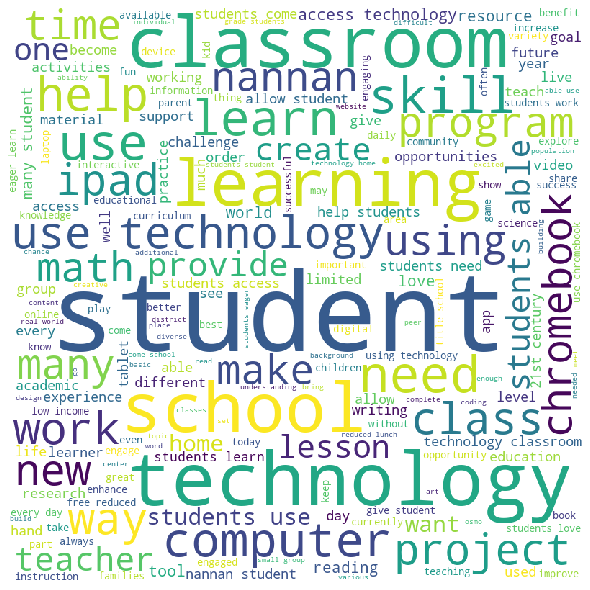

Summary of words in Cluster 4 :
Number of words in the cluster: 37666
Most frequent words in the cluster: [('students', 2383), ('technology', 1006), ('school', 604), ('use', 573), ('classroom', 562), ('learning', 510), ('learn', 331), ('access', 313), ('many', 295), ('help', 273)]



Essay Wordcloud for cluster 5 :


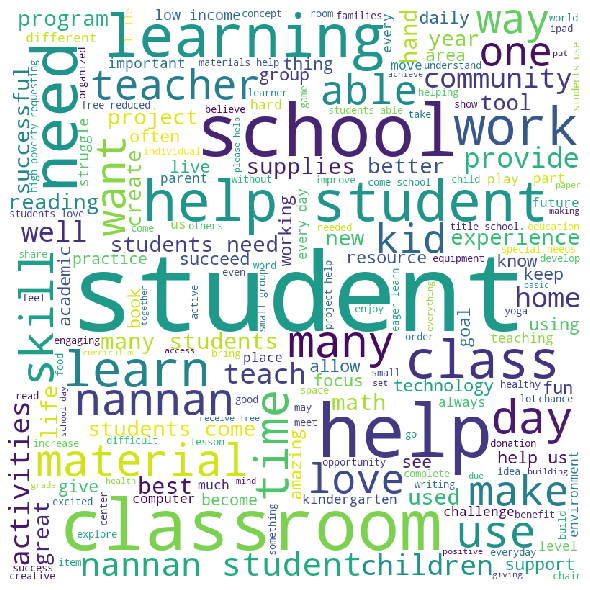

Summary of words in Cluster 5 :
Number of words in the cluster: 41309
Most frequent words in the cluster: [('students', 2151), ('help', 1129), ('school', 722), ('classroom', 436), ('learning', 407), ('learn', 343), ('need', 342), ('many', 307), ('nannan', 297), ('skills', 270)]



Essay Wordcloud for cluster 6 :


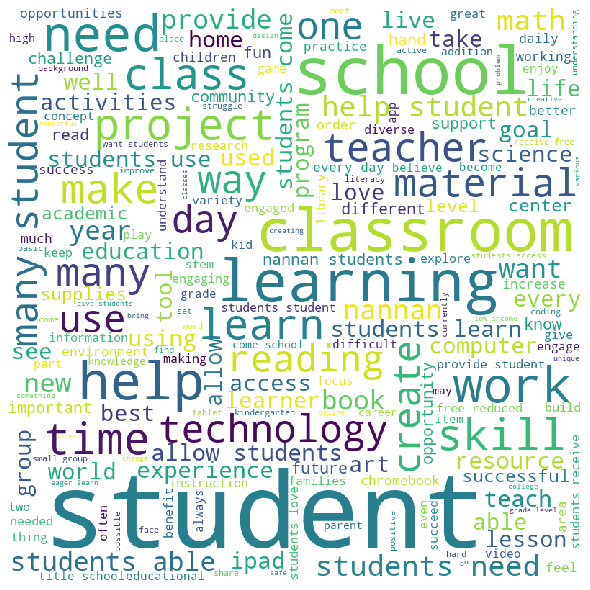

Summary of words in Cluster 6 :
Number of words in the cluster: 37900
Most frequent words in the cluster: [('students', 2854), ('school', 664), ('learning', 448), ('help', 372), ('learn', 356), ('classroom', 322), ('many', 321), ('need', 254), ('skills', 239), ('use', 237)]



Essay Wordcloud for cluster 7 :


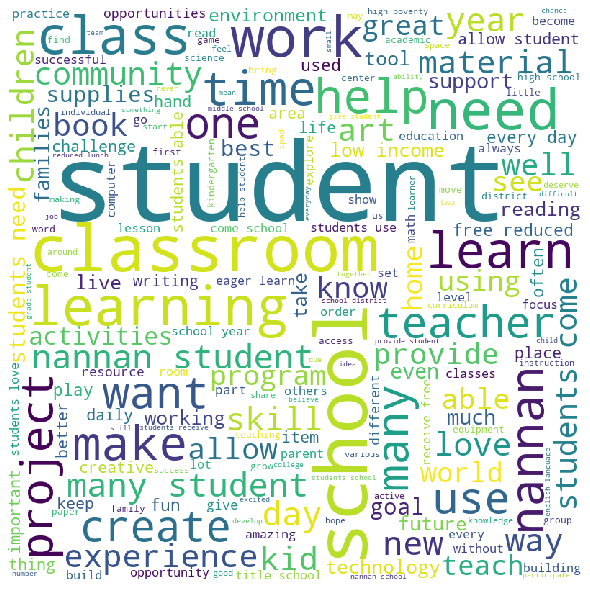

Summary of words in Cluster 7 :
Number of words in the cluster: 113188
Most frequent words in the cluster: [('students', 5873), ('school', 2403), ('many', 913), ('learn', 901), ('nannan', 901), ('classroom', 865), ('learning', 751), ('work', 685), ('need', 683), ('come', 599)]



Essay Wordcloud for cluster 8 :


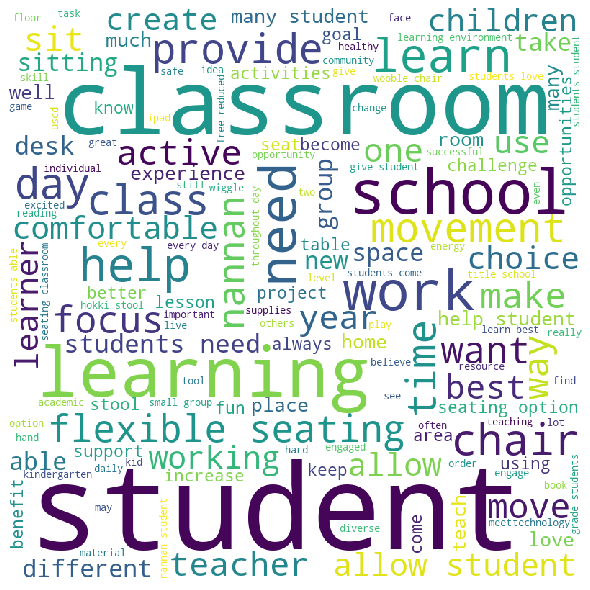

Summary of words in Cluster 8 :
Number of words in the cluster: 35291
Most frequent words in the cluster: [('students', 2310), ('classroom', 968), ('learning', 674), ('school', 503), ('learn', 331), ('seating', 318), ('work', 303), ('day', 297), ('help', 265), ('need', 222)]



Essay Wordcloud for cluster 9 :


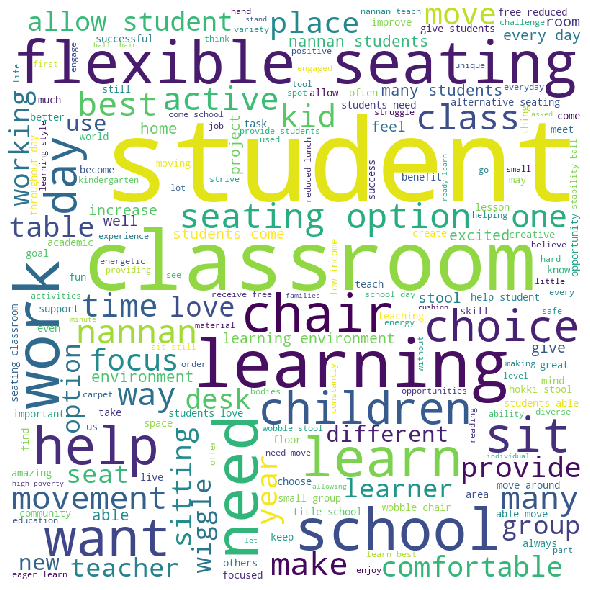

Summary of words in Cluster 9 :
Number of words in the cluster: 41743
Most frequent words in the cluster: [('students', 2039), ('classroom', 798), ('learning', 677), ('seating', 602), ('school', 510), ('learn', 426), ('work', 386), ('day', 355), ('move', 355), ('flexible', 324)]



Essay Wordcloud for cluster 10 :


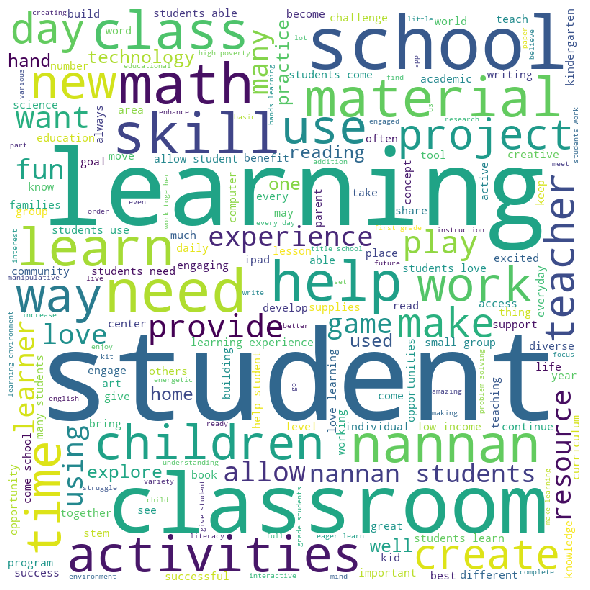

Summary of words in Cluster 10 :
Number of words in the cluster: 43451
Most frequent words in the cluster: [('students', 2265), ('learning', 1442), ('school', 645), ('classroom', 523), ('math', 436), ('learn', 401), ('skills', 320), ('nannan', 305), ('materials', 297), ('help', 283)]



Essay Wordcloud for cluster 11 :


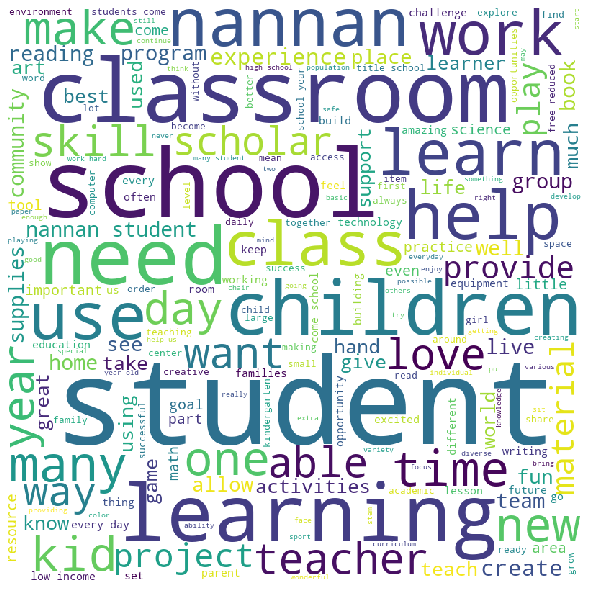

Summary of words in Cluster 11 :
Number of words in the cluster: 83323
Most frequent words in the cluster: [('students', 1935), ('school', 1484), ('learning', 753), ('classroom', 736), ('nannan', 649), ('children', 623), ('learn', 596), ('help', 577), ('need', 535), ('many', 521)]



Essay Wordcloud for cluster 12 :


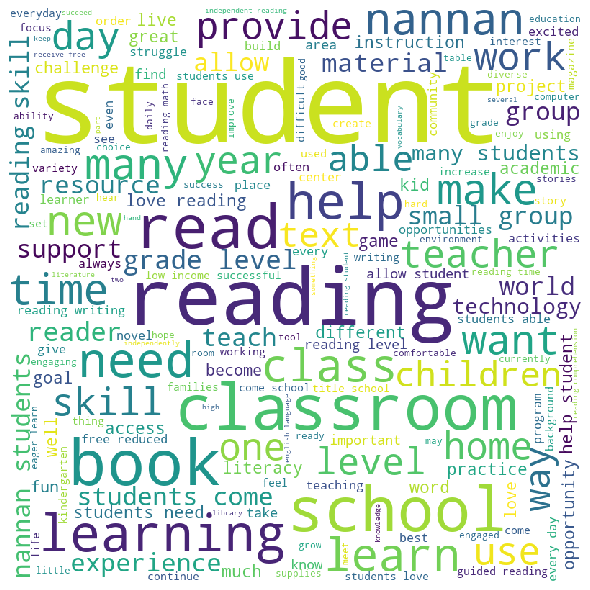

Summary of words in Cluster 12 :
Number of words in the cluster: 31025
Most frequent words in the cluster: [('students', 1775), ('reading', 1104), ('school', 455), ('classroom', 311), ('read', 282), ('help', 275), ('many', 233), ('learning', 231), ('skills', 224), ('nannan', 223)]



Essay Wordcloud for cluster 13 :


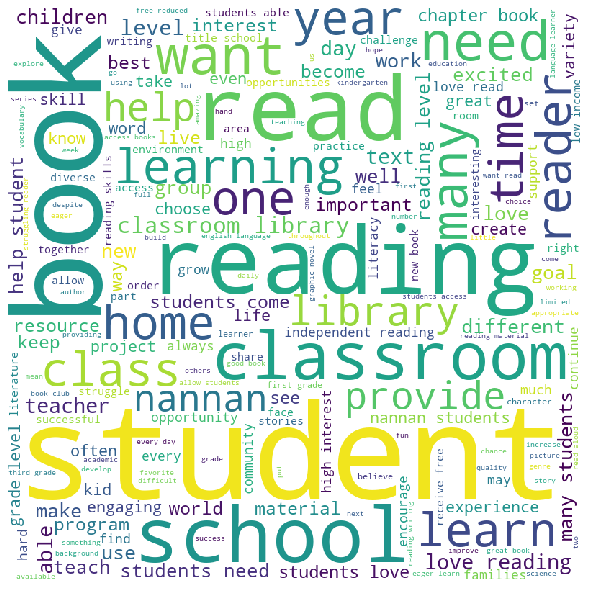

Summary of words in Cluster 13 :
Number of words in the cluster: 23706
Most frequent words in the cluster: [('students', 1409), ('books', 900), ('reading', 762), ('read', 488), ('school', 386), ('classroom', 277), ('love', 242), ('book', 229), ('many', 201), ('library', 184)]



Essay Wordcloud for cluster 14 :


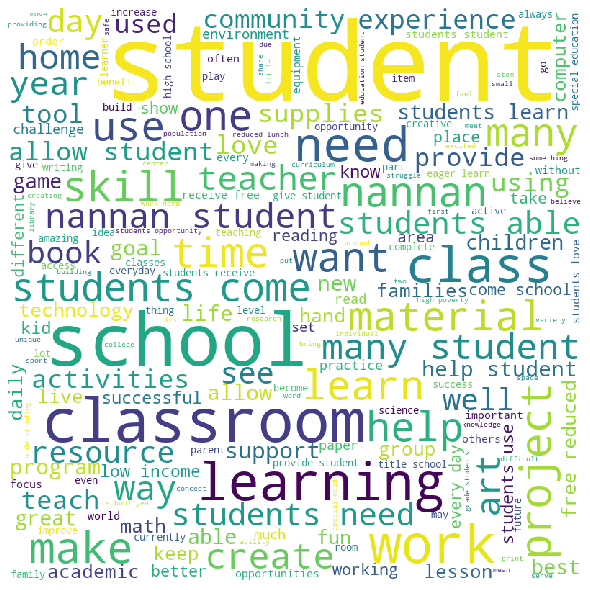

Summary of words in Cluster 14 :
Number of words in the cluster: 90506
Most frequent words in the cluster: [('students', 6344), ('school', 1764), ('learn', 724), ('learning', 720), ('classroom', 680), ('work', 647), ('many', 634), ('need', 602), ('nannan', 594), ('help', 563)]





In [30]:
for i in range(0,15):
    dfi=cluster_map[cluster_map.cluster == i]
    print("Essay Wordcloud for cluster {} :".format(i))
    from wordcloud import WordCloud
    from collections import Counter

    words = ' '
    for row in dfi['essay'].values:
        tokens = row.split()
        for t in tokens:
            words += t + ' '

    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(words)

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
    word_count=len(words.split())  #https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/
    Counter = Counter(words.split())
    most_occur = Counter.most_common(10)
    print("Summary of words in Cluster {} :".format(i))
    print("Number of words in the cluster: {}".format(word_count))
    print("Most frequent words in the cluster: {}".format(most_occur))
    print('\n\n')

## 4. Apply Agglomerative Clustering

### 4.1 Estimate the number of clusters using a Dendogram

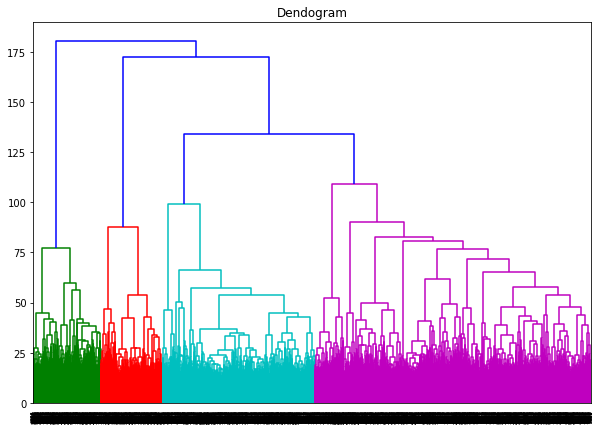

In [37]:
# Ref: https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/

import scipy.cluster.hierarchy as shc

X_agg = X_final.todense() #was getting a value error, hence converted to dense matrix

plt.figure(figsize=(10, 7))  
plt.title("Dendogram")  
dend = shc.dendrogram(shc.linkage(X_agg, method='ward'))

- From the above dendrogram clearlyn_clusters= 4

In [38]:
np.save('dense',X_agg)

In [40]:
X_new=np.load('dense.npy')

### 4.2 Agglomerative Clustering on n_clusters

In [41]:
from sklearn.cluster import AgglomerativeClustering

clf3 = AgglomerativeClustering(n_clusters= 4, affinity='euclidean', linkage='ward')  
clf3.fit_predict(X_new)

array([0, 0, 0, ..., 1, 2, 1], dtype=int64)

### 4.3 Dataframe contaning the cluster numbers and the text

In [42]:
#Ref: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-samples-points-in-each-clusters

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['essay']= X['preprocessed_essays'].values
cluster_map['cluster'] = clf3.labels_

In [43]:
cluster_map.head(5)

data_index                                              essay  cluster
0           0  students english learners working english seco...        0
1           1  students arrive school eager learn polite gene...        0
2           2  true champions always ones win guts mia hamm q...        0
3           3  work unique school filled esl english second l...        0
4           4  second grade classroom next year made around 2...        0

### 4.4 Essay Wordcloud

Essay Wordcloud for cluster 0 :


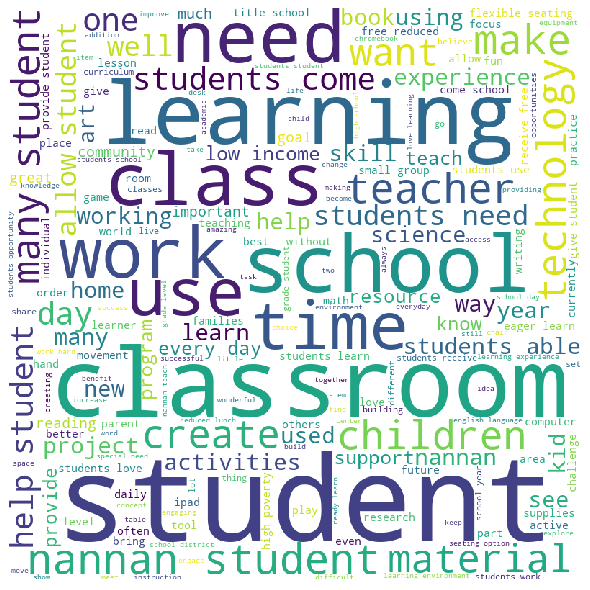

Summary of words in Cluster 0 :
Number of words in the cluster: 342371
Most frequent words in the cluster: [('students', 18837), ('school', 5699), ('learning', 4672), ('classroom', 4120), ('learn', 2911), ('help', 2818), ('nannan', 2371), ('many', 2340), ('work', 2237), ('need', 2107)]



Essay Wordcloud for cluster 1 :


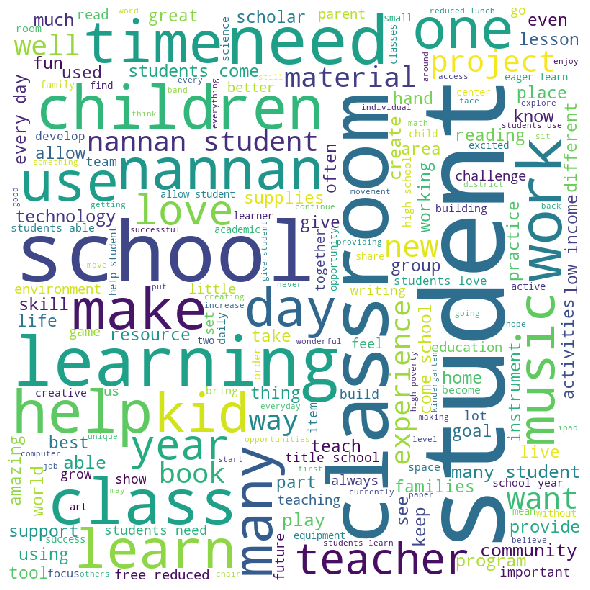

Summary of words in Cluster 1 :
Number of words in the cluster: 170258
Most frequent words in the cluster: [('students', 6721), ('school', 3339), ('classroom', 1665), ('learning', 1572), ('learn', 1362), ('nannan', 1317), ('many', 1258), ('help', 1227), ('need', 1063), ('work', 990)]



Essay Wordcloud for cluster 2 :


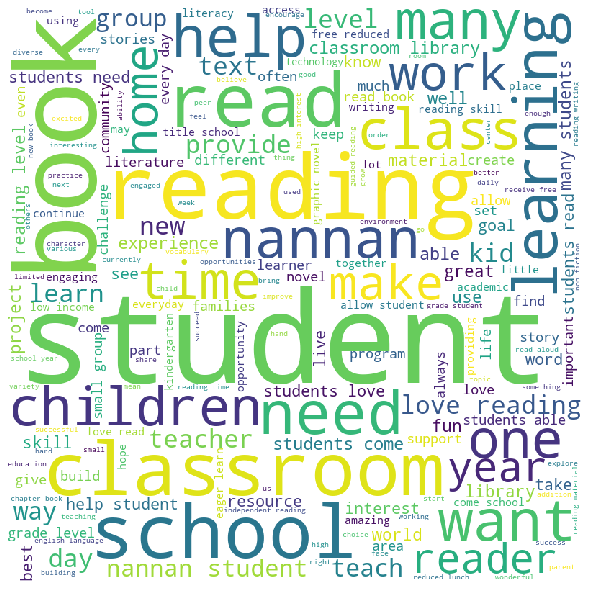

Summary of words in Cluster 2 :
Number of words in the cluster: 72973
Most frequent words in the cluster: [('students', 3704), ('reading', 2070), ('books', 1762), ('read', 1210), ('school', 1143), ('classroom', 790), ('love', 698), ('help', 605), ('learning', 537), ('learn', 530)]



Essay Wordcloud for cluster 3 :


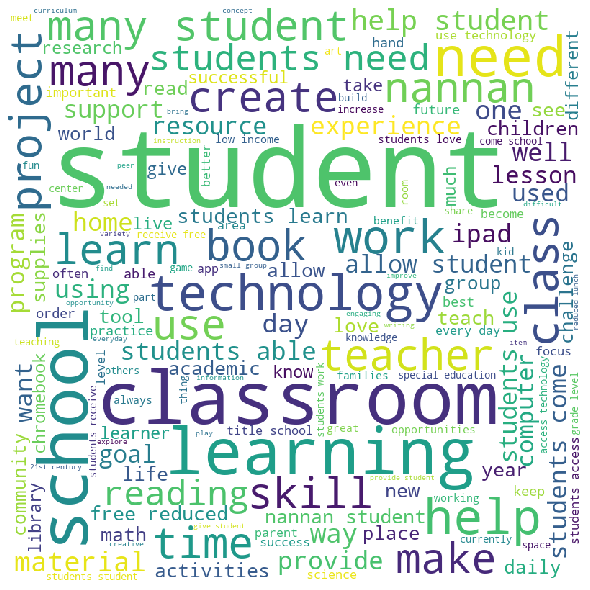

Summary of words in Cluster 3 :
Number of words in the cluster: 101758
Most frequent words in the cluster: [('students', 7062), ('school', 1715), ('learning', 1343), ('classroom', 1342), ('technology', 1019), ('help', 902), ('learn', 876), ('use', 767), ('many', 756), ('need', 683)]





In [45]:
for i in range(0,4):
    dfi=cluster_map[cluster_map.cluster == i]
    print("Essay Wordcloud for cluster {} :".format(i))
    from wordcloud import WordCloud
    from collections import Counter

    words = ' '
    for row in dfi['essay'].values:
        tokens = row.split()
        for t in tokens:
            words += t + ' '

    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(words)

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
    word_count=len(words.split())  #https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/
    Counter = Counter(words.split())
    most_occur = Counter.most_common(10)
    print("Summary of words in Cluster {} :".format(i))
    print("Number of words in the cluster: {}".format(word_count))
    print("Most frequent words in the cluster: {}".format(most_occur))
    print('\n\n')

## 5. Apply DBSCAN

In [33]:
import math
print(math.log(5000))

8.517193191416238


- Ref: https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030
- Heuristic approach to determine minPts is ln(n), where n is the total number of points to be clustered.
- Therefore minPts = ln(5000) = 8

### 5.1 Best ‘eps’ using the elbow-knee method

Text(0, 0.5, 'eps-values')

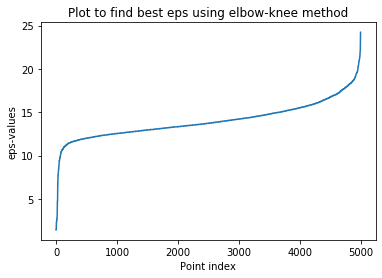

In [50]:
#Ref:https://datascience.stackexchange.com/questions/10162/knn-distance-plot-for-determining-eps-of-dbscan
#https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=8).fit(X_new)
distances, indices = nbrs.kneighbors(X_new)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

#plt.plot(indices, distances)
plt.title("Plot to find best eps using elbow-knee method")
plt.xlabel('Point index')
plt.ylabel('eps-values')

### 5.2 DBSCAN on best eps

In [51]:
from sklearn.cluster import DBSCAN

clf4 = DBSCAN(eps=15, min_samples=8).fit(X_new)

### 5.3 Dataframe contaning the cluster numbers and the text

In [52]:
#Ref: https://stackoverflow.com/questions/36195457/python-sklearn-kmeans-how-to-get-the-samples-points-in-each-clusters

cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['essay']= X['preprocessed_essays'].values
cluster_map['cluster'] = clf4.labels_

In [53]:
cluster_map.head(5)

data_index                                              essay  cluster
0           0  students english learners working english seco...       -1
1           1  students arrive school eager learn polite gene...        0
2           2  true champions always ones win guts mia hamm q...       -1
3           3  work unique school filled esl english second l...        0
4           4  second grade classroom next year made around 2...        0

In [55]:
cluster_map['cluster'].unique()

array([-1,  0], dtype=int64)

- There are just 2 clusters with one being a noise cluster. Therefore n_clusters=1

### 5.4 Essay Wordcloud

Essay Wordcloud for cluster 0 :


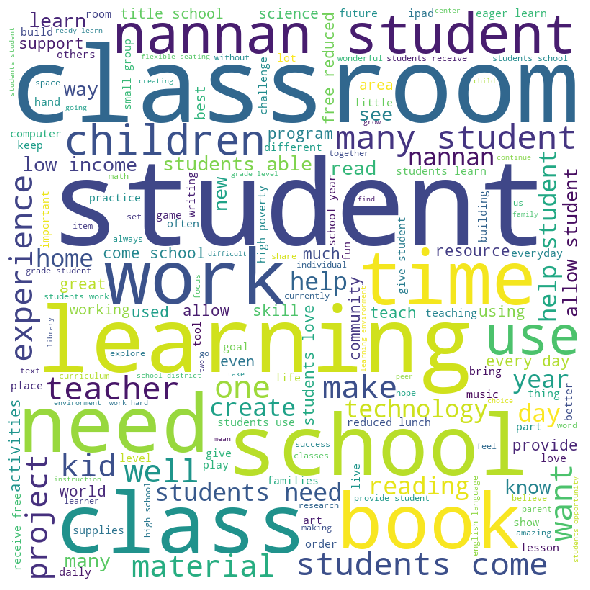

Summary of words in Cluster 0 :
Number of words in the cluster: 443120
Most frequent words in the cluster: [('students', 23505), ('school', 8121), ('learning', 5241), ('classroom', 5025), ('learn', 3775), ('help', 3657), ('nannan', 3496), ('many', 3302), ('need', 2833), ('work', 2713)]





In [61]:
for i in range(0,1):
    dfi=cluster_map[cluster_map.cluster == i]
    print("Essay Wordcloud for cluster {} :".format(i))
    from wordcloud import WordCloud
    from collections import Counter

    words = ' '
    for row in dfi['essay'].values:
        tokens = row.split()
        for t in tokens:
            words += t + ' '

    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(words)

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
    
    word_count=len(words.split())  #https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/
    Counter = Counter(words.split())
    most_occur = Counter.most_common(10)
    print("Summary of words in Cluster {} :".format(i))
    print("Number of words in the cluster: {}".format(word_count))
    print("Most frequent words in the cluster: {}".format(most_occur))
    print('\n\n')

- It can be seen that DBSCAN did not perform well on my data set as there was only 1 cluster